In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:22pt;}
div.text_cell_render.rendered_html{font-size:18pt;}
div.text_cell_render.rendered_html{font-size:15pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:18pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:18pt;padding:5px;}
table.dataframe{font-size:18px;}
</style>
"""))

<span style='color:orange; font-size: 35px; font-weith:bold;'>CH4_RNN(Recurrent Neural Network 순환신경망)</span>

# 1.문맥을 이용하여 모델만들기 (다음 단어 예측)

In [31]:
text = """경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다"""

# text1 = "장마철이 오고 있다"

In [26]:
# from keras_preprocessing.text import Tokenizer
# t = Tokenizer()
# t.fit_on_texts([text,text1])
# encoded = t.texts_to_sequences([text,text1])
# print(encoded)
# print(t.word_index) # 딕셔너리로 반환 

In [32]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])
print(encoded)
print(t.word_index) # 딕셔너리로 반환 

[[2, 3, 1, 4, 5, 6, 1, 7, 8, 1, 9, 10, 1, 11]]
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
# 문자열 리스트를 인덱스 시퀀스로 변환
# text_to_sequences는 batch입력을 전제로 하여 항상 2차원 리스트로 반환
print(t.texts_to_sequences(['경마장에 말이 있다','말이 뛴다']))
print(t.texts_to_sequences(['가는 말이 곱다'])[0])
# 단일 문장을 바로쓰기위해 [0]을 붙여서 작성

[[2, 1, 5], [1]]
[8, 1, 11]


In [33]:
# word_index : 단어 -> 정수 인덱스로 매핑된 dict
for key,value in t.word_index.items():
    print(key,value)

말이 1
경마장에 2
있는 3
뛰고 4
있다 5
그의 6
법이다 7
가는 8
고와야 9
오는 10
곱다 11


In [46]:
# 학습을 시키기 위해 ['경마장에 있는','경마장에 있는 말이',...]
sequences = []
for line in text.split('\n'):
    print('원문장 :', line)
    encoded = t.texts_to_sequences([line])[0]
    print('encoded된 문장(단어->숫자):',encoded)
    for i in range(0,len(encoded)-1):       # i:시작index
        for j in range(i+2, len(encoded)+1): # j:끝나는 index바로 뒤 i+2는 [0:3]이런식으로 하기위해 
            sequences.append(encoded[i:j])
print('sequences와 해석 출력')
for sequence in sequences:
    for word_seq in sequence:
        for word, id in t.word_index.items():
            if word_seq==id:
                print("{}:{}".format(word_seq,word),end=' ') # end는 개행 안하려고 작성
                break
    print()

원문장 : 경마장에 있는 말이 뛰고 있다
encoded된 문장(단어->숫자): [2, 3, 1, 4, 5]
원문장 : 그의 말이 법이다
encoded된 문장(단어->숫자): [6, 1, 7]
원문장 : 가는 말이 고와야 오는 말이 곱다
encoded된 문장(단어->숫자): [8, 1, 9, 10, 1, 11]
sequences와 해석 출력
2:경마장에 3:있는 
2:경마장에 3:있는 1:말이 
2:경마장에 3:있는 1:말이 4:뛰고 
2:경마장에 3:있는 1:말이 4:뛰고 5:있다 
3:있는 1:말이 
3:있는 1:말이 4:뛰고 
3:있는 1:말이 4:뛰고 5:있다 
1:말이 4:뛰고 
1:말이 4:뛰고 5:있다 
4:뛰고 5:있다 
6:그의 1:말이 
6:그의 1:말이 7:법이다 
1:말이 7:법이다 
8:가는 1:말이 
8:가는 1:말이 9:고와야 
8:가는 1:말이 9:고와야 10:오는 
8:가는 1:말이 9:고와야 10:오는 1:말이 
8:가는 1:말이 9:고와야 10:오는 1:말이 11:곱다 
1:말이 9:고와야 
1:말이 9:고와야 10:오는 
1:말이 9:고와야 10:오는 1:말이 
1:말이 9:고와야 10:오는 1:말이 11:곱다 
9:고와야 10:오는 
9:고와야 10:오는 1:말이 
9:고와야 10:오는 1:말이 11:곱다 
10:오는 1:말이 
10:오는 1:말이 11:곱다 
1:말이 11:곱다 


In [48]:
# 시퀀스 길이 맞추기 작업 : 패딩(padding) 
print([len(sequence) for sequence in sequences])
my_len = max(len(sequence) for sequence in sequences)
my_len

[2, 3, 4, 5, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 4, 5, 6, 2, 3, 4, 5, 2, 3, 4, 2, 3, 2]


6

In [52]:
# sequences를 훈련 가능하도록 모두 6개로 조정 (0을 넣기위한 작업)
# 내가 원하는대로 앞 또는 뒤에 넣을 수 있음
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences=sequences,
                                maxlen=my_len,    # my_len:6으로 맞추고
                                padding='pre')    # 앞쪽에 0을 붙임 
# padded_sequences
padded_sequences.shape, type(padded_sequences)

((28, 6), numpy.ndarray)

In [66]:
# 독립변수(X)와 타겟변수(y)로 분리
# 맨 마지막 1개 제외하고 모두 X, 마지막 1개 y
X = padded_sequences[:,:-1]
y = padded_sequences[:,-1]
X.shape,y.shape

((28, 5), (28,))

In [58]:
# 컴퓨터가 X를 임베딩 작업할 때 필요한 입력 bit 수(단어수+1) : X 처리 (X를 위하여)
# t.word_index는 11개의 단어이지만 0까지 포함해서 12개로 담김 (원핫인코딩,argmax편하기 위해)
input_dim = len(t.word_index)+1
input_dim

12

In [62]:
# y의 원핫인코딩
# input_dim이 12이므로 백터릐 길이를 지정 / 안 하면 최대값 +1로 자동 계산이 되므로 누락이 있을 수 있음 
from tensorflow.keras.utils import to_categorical
Y = to_categorical(y, input_dim)
X.shape,Y.shape,input_dim

((28, 5), (28, 12), 12)

In [ ]:
# 2. 모델 생성하기

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding # Xi의 원핫인코딩한 희소행렬 변환
from tensorflow.keras.layers import SimpleRNN ,Dense
import matplotlib.pyplot as plt

In [67]:
model = Sequential()
model.add(Embedding(input_dim=input_dim,      # 입력받은 값을 12개로 원핫인코딩
                    output_dim=10,            # 임베딩 출력의 갯수 
                    input_length=X.shape[1])) # 입력단어,독립변수(X)의 수 
model.add(SimpleRNN(units=32))                # 12 -> 10 -> 32 (Tanh)
model.add(Dense(12, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 10)             120       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# 3. 모델 학습 과정 설정

In [68]:
# 모델 학습 과정 설정 / y를 원핫인코딩 안하면 pars
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# 4. 모델 학습 시키기

In [69]:
hist = model.fit(X,Y, epochs=300, verbose=2)

Epoch 1/300
1/1 - 1s - loss: 2.4792 - accuracy: 0.1071 - 896ms/epoch - 896ms/step
Epoch 2/300
1/1 - 0s - loss: 2.4669 - accuracy: 0.1071 - 3ms/epoch - 3ms/step
Epoch 3/300
1/1 - 0s - loss: 2.4546 - accuracy: 0.1071 - 4ms/epoch - 4ms/step
Epoch 4/300
1/1 - 0s - loss: 2.4423 - accuracy: 0.1071 - 4ms/epoch - 4ms/step
Epoch 5/300
1/1 - 0s - loss: 2.4299 - accuracy: 0.1786 - 4ms/epoch - 4ms/step
Epoch 6/300
1/1 - 0s - loss: 2.4172 - accuracy: 0.1786 - 5ms/epoch - 5ms/step
Epoch 7/300
1/1 - 0s - loss: 2.4042 - accuracy: 0.2143 - 4ms/epoch - 4ms/step
Epoch 8/300
1/1 - 0s - loss: 2.3906 - accuracy: 0.2500 - 5ms/epoch - 5ms/step
Epoch 9/300
1/1 - 0s - loss: 2.3766 - accuracy: 0.2857 - 4ms/epoch - 4ms/step
Epoch 10/300
1/1 - 0s - loss: 2.3619 - accuracy: 0.3214 - 4ms/epoch - 4ms/step
Epoch 11/300
1/1 - 0s - loss: 2.3466 - accuracy: 0.3571 - 3ms/epoch - 3ms/step
Epoch 12/300
1/1 - 0s - loss: 2.3306 - accuracy: 0.3214 - 5ms/epoch - 5ms/step
Epoch 13/300
1/1 - 0s - loss: 2.3139 - accuracy: 0.3571 -

Epoch 105/300
1/1 - 0s - loss: 1.1599 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 106/300
1/1 - 0s - loss: 1.1494 - accuracy: 0.6071 - 4ms/epoch - 4ms/step
Epoch 107/300
1/1 - 0s - loss: 1.1390 - accuracy: 0.6071 - 4ms/epoch - 4ms/step
Epoch 108/300
1/1 - 0s - loss: 1.1288 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 109/300
1/1 - 0s - loss: 1.1187 - accuracy: 0.6071 - 4ms/epoch - 4ms/step
Epoch 110/300
1/1 - 0s - loss: 1.1088 - accuracy: 0.6071 - 3ms/epoch - 3ms/step
Epoch 111/300
1/1 - 0s - loss: 1.0991 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 112/300
1/1 - 0s - loss: 1.0895 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 113/300
1/1 - 0s - loss: 1.0801 - accuracy: 0.6429 - 3ms/epoch - 3ms/step
Epoch 114/300
1/1 - 0s - loss: 1.0708 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 115/300
1/1 - 0s - loss: 1.0616 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 116/300
1/1 - 0s - loss: 1.0526 - accuracy: 0.6429 - 4ms/epoch - 4ms/step
Epoch 117/300
1/1 - 0s - loss: 1.0438 - 

Epoch 208/300
1/1 - 0s - loss: 0.5295 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 209/300
1/1 - 0s - loss: 0.5260 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 210/300
1/1 - 0s - loss: 0.5225 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 211/300
1/1 - 0s - loss: 0.5190 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 212/300
1/1 - 0s - loss: 0.5156 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 213/300
1/1 - 0s - loss: 0.5122 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 214/300
1/1 - 0s - loss: 0.5088 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 215/300
1/1 - 0s - loss: 0.5055 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 216/300
1/1 - 0s - loss: 0.5021 - accuracy: 0.8214 - 4ms/epoch - 4ms/step
Epoch 217/300
1/1 - 0s - loss: 0.4989 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 218/300
1/1 - 0s - loss: 0.4956 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 219/300
1/1 - 0s - loss: 0.4924 - accuracy: 0.8214 - 3ms/epoch - 3ms/step
Epoch 220/300
1/1 - 0s - loss: 0.4892 - 

In [99]:
# 5. 모델 학습과정 그래프

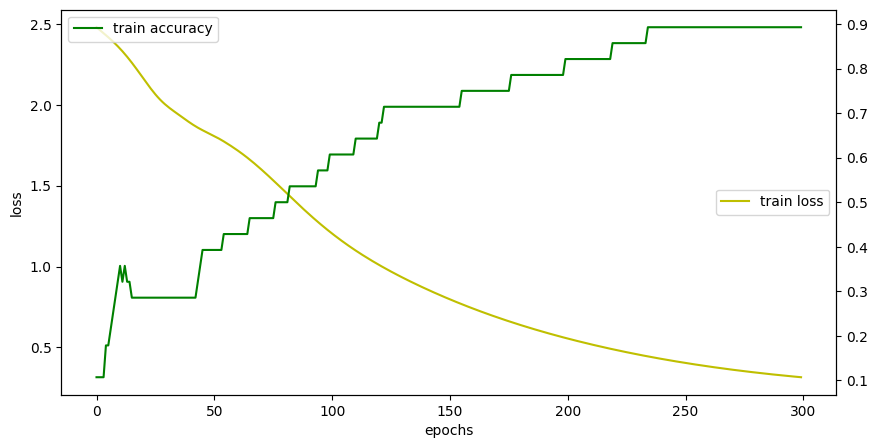

In [70]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax= loss_ax.twinx() #x축 공유
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()


In [85]:
# 모델 사용하기 ('경마장에 있는 말이' -> '뛰고)
encoded = t.texts_to_sequences(['경마장에 있는 말이'])[0]
input_data = pad_sequences([encoded], maxlen=my_len-1, padding='pre')
print('입력 데이터:',input_data)
result = model.predict(input_data).argmax()
word = t.index_word.get(result,'??')
print('예측된 단어:',word)

입력 데이터: [[0 0 2 3 1]]
1/1 [==============================] - 0s 31ms/step
예측된 단어: 뛰고


In [97]:
# 사용자한테 받기
input_word = input('입력 단어 :')
encoded = t.texts_to_sequences([input_word])[0]
input_data = pad_sequences([encoded], maxlen=my_len-1, padding='pre')
print('입력 데이터:',input_data)
result = model.predict(input_data, verbose=0).argmax()
word = t.index_word.get(result,'??')
print('예측된 단어:',word)

입력 단어 :뛰고
입력 데이터: [[0 0 0 0 4]]
예측된 단어: 있다


In [98]:
t.texts_to_sequences(['없는 단어']) # 없는 단어는 안 나옴

[[]]

# 2. 다음 문맥 예측해 보기

In [127]:
# "0000" 이후에 올 단어 n개 예측하기
# "경마장에" → "있는" → "말이" ...
def sentence_generation(current_word, n):
#     print('입력된 단어 :', current_word)
    for i in range(1, n+1):
        encoded = t.texts_to_sequences([current_word])[0]                      # 2로 나움
        input_data = pad_sequences([encoded], maxlen=my_len-1, padding='pre')  # 문자->숫자로 변환
        result = model.predict(input_data, verbose=0).argmax()
        word = t.index_word[result]
        current_word = current_word+ ' ' + word
#         print('{}번째 생성 문맥 : {} ({},{}):'.format(i,
#                                                 current_word,
#                                                 encoded,
#                                                 result))
    return current_word
sentence_generation('경마장에', 3)

'경마장에 있는 말이 뛰고'

In [128]:
sentence_generation('가는', 5)

'가는 말이 고와야 오는 말이 곱다'